## 0. Init and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


drive.flush_and_unmount()  
All changes made in this colab session should now be visible in Drive.

In [0]:
#imports

from math import sqrt
from datetime import datetime, timedelta

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pandas import read_csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [0]:
data_path =  r"/content/drive/My Drive/colabData/"

In [5]:
data_path

'/content/drive/My Drive/colabData/'

## 1. Read the raw csv data

In [0]:
cols=['id', 'created_at', 'destroyed_at']
server_data = pd.read_csv(data_path + "servers.csv", delimiter=",", names=cols, header=None )

In [0]:
cols=['timestamp', 'device_id', 'user_id','server_id', 'connected']
dtypes = {'timestamp': 'str', 'device_id': 'int', 'user_id': 'int', 'server_id': 'int', 'connected':'bool'}
parse_dates = ['timestamp']
events_data = pd.read_csv(data_path + "connectivity_events.csv", delimiter=",", names=cols, header=None,dtype=dtypes, parse_dates=parse_dates )

In [0]:
events_data.shape

(9308207, 5)

In [0]:
events_data.columns

Index(['timestamp', 'device_id', 'user_id', 'server_id', 'connected'], dtype='object')

In [0]:
events_data.dtypes

timestamp    datetime64[ns]
device_id             int64
user_id               int64
server_id             int64
connected              bool
dtype: object

## 2. Fill and process the device event stream data 

In [0]:
# start, end takes pandas.Timestamp
def fillDates(start, end):
    #print("fillDates", type(start), start, type(end),end)
    dates = list()
    for i in  range(1,(end.date() - start.date()).days):
        oneday = pd.Timedelta('%d days'%i)
        dates.append(start + oneday)
    return dates

In [0]:
def processEventStream(row):
    r = list()
    dates = list()
    #print(row)

    try:
        if (device_state[row[1]]):
            #print("device details exist")
            #print(row)
            timestamp = row [0]
            device_id = row [1]
            user_id = row [2]
            server_id = row [3]
            next_event = row [4]
            
            if device_state[row[1]]["state"]: # current event 'online'
                if next_event: # next event 'online'
                    if device_state[row[1]]["server"] == server_id: # case 1
                        # Assume device was online from current event's timestamp until next event's timestamp
                        dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    else: # case 2 different server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        if (pd.Timestamp(destruction_time) < timestamp):
                            dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        else:
                            dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    
                    #update the state dictionary Case 1 & 2
                    state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                    device_state[device_id] = state_dict        
                else:# next event 'offline', 
                    if device_state[row[1]]["server"] == server_id: # case 3 Normal case, same next server
                        #update the state dictionary Case 3
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                    else:# case 4, different next server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        # *NO* update for the state dictionary in Case 4
            else:  # current event 'offline'
                if next_event: # next event 'online' # case 5 & case 6: Normal Case
                        #update the state dictionary: case 5 & 6
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                        dates = list().append(timestamp)
                else: # next event 'offline' # case 7 &  case 8
                        pass # Ignore next event
                
            if dates:
                for d in dates:
                    newentry = list()
                    newentry.append(d)
                    newentry.append(device_id)
                    newentry.append(user_id)
                    #print(newentry)
                    rows_list.append(newentry)
                #print("more dates", dates)
            
    except KeyError:
        state_dict = {"state":row[4], "server":row[3], "timestamp":row[0]}
        device_state[row[1]] = state_dict
        #print(row[1], device_state[row[1]])
        if (row[4]):
            r = row.tolist()
            #print("r",type(r))
            rows_list.append(r[0:3]) 

    return r


In [0]:
device_state = dict()
rows_list = list()
#print( device_state)
#df = small_data.apply(processEventStream, axis=1)
events_data=events_data.apply(processEventStream, axis=1)

## 3. Calculate daily number of (unique) devices connected

In [0]:
events_data_connected =  pd.DataFrame(rows_list)
events_data_connected.columns = ["timestamp", "device_id", "user_id"]

In [0]:
events_data_connected=events_data_connected.dropna()

In [0]:
events_data_connected['date'] = pd.DatetimeIndex(events_data_connected['timestamp']).date

In [0]:
events_data_connected = events_data_connected.drop(columns=['timestamp'])

In [0]:
events_data_connected.columns

Index(['device_id', 'user_id', 'date'], dtype='object')

In [0]:
unique_device_per_day = events_data_connected.drop_duplicates(["date", "device_id"],keep = "first")

In [0]:
unique_device_per_day.to_csv(data_path + "unique_device_daily.csv", index=False)

In [0]:
!head /content/drive/My\ Drive/colabData/unique_device_daily.csv

device_id,user_id,date
100,4,2015-05-31
101,1,2015-05-31
102,1,2015-05-31
103,26,2015-05-31
104,1,2015-05-31
105,1,2015-05-31
106,1,2015-05-31
10,6,2015-05-31
107,1,2015-05-31


## 3.1 Read unique_device_per_day from the csv instead of processing again and again

In [0]:
#cols=['id', 'created_at', 'destroyed_at']
df_device_daily = pd.read_csv(data_path + "unique_device_daily.csv", delimiter=",")

In [0]:
df_device_daily.head

<bound method NDFrame.head of        device_id  user_id        date
0            100        4  2015-05-31
1            101        1  2015-05-31
2            102        1  2015-05-31
3            103       26  2015-05-31
4            104        1  2015-05-31
...          ...      ...         ...
56582      56298     4445  2018-02-28
56583      56299     5455  2018-02-28
56584      56300     4824  2018-02-28
56585      56301     4445  2018-02-28
56586      56302     5219  2018-02-28

[56587 rows x 3 columns]>

In [0]:
#dev_count_perday_peruser = unique_device_per_day.groupby(['date', 'user_id']).agg({'device_id':["count"]})

In [0]:
#dev_count_perday_peruser.columns

In [0]:
#dev_count_perday_peruser

In [0]:
dev_count_perday = df_device_daily.groupby(['date'])['device_id'].count().reset_index(name='count')

In [0]:
dev_count_perday

,date,count
0,2015-05-31,272
1,2015-06-01,35
2,2015-06-02,41
3,2015-06-03,30
4,2015-06-04,21
...,...,...
1000,2018-02-24,121
1001,2018-02-25,98
1002,2018-02-26,179
1003,2018-02-27,212


#### Chart device count per day

default: [24.0, 10.0]


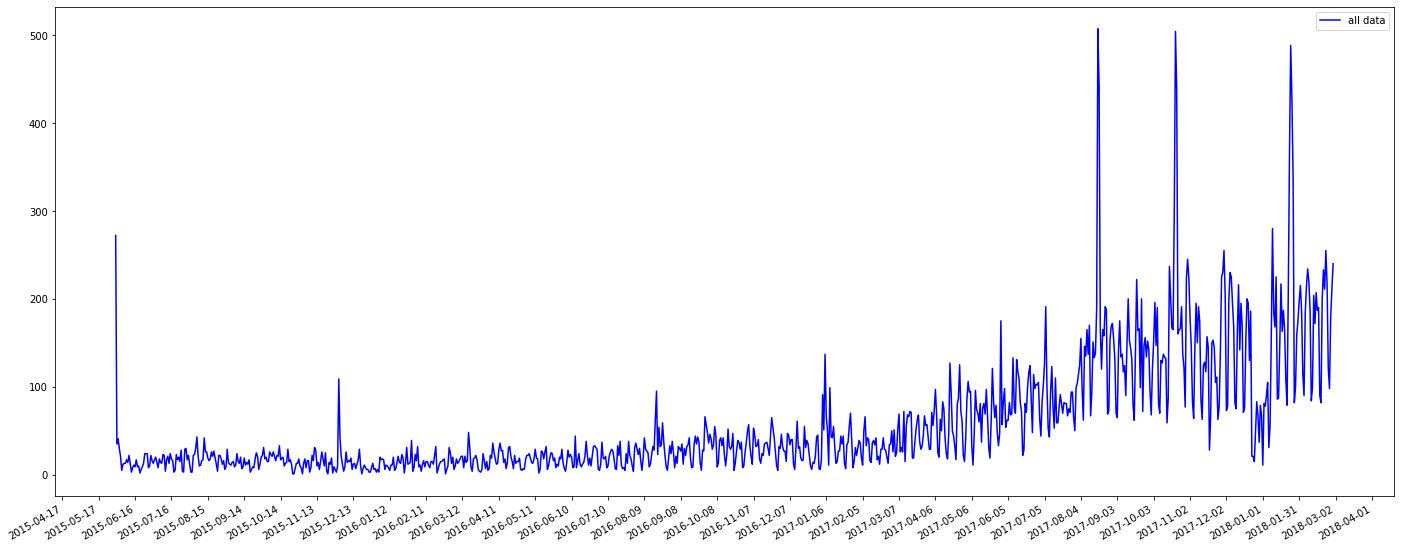

In [0]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(dev_count_perday["date"], dev_count_perday["count"], "-b", label='all data')
plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

In [0]:
dev_count_perday = dev_count_perday[1:]

In [0]:
dev_count_perday[0:3]

,date,count
1,2015-06-01,35
2,2015-06-02,41
3,2015-06-03,30


## 4. Monthly estimation

In [0]:
dev_count_monthly = dev_count_perday.copy()
dev_count_monthly.date = pd.to_datetime(dev_count_monthly.date)
dev_count_monthly.set_index('date', inplace=True)

In [0]:
dev_count_monthly = dev_count_monthly.resample('M', label='right').sum()

In [0]:
dev_count_monthly.shape

(33, 1)

In [0]:
dev_count_monthly

,count
date,
2015-06-30,461
2015-07-31,503
2015-08-31,589
2015-09-30,428
2015-10-31,514
2015-11-30,384
2015-12-31,472
2016-01-31,410
2016-02-29,388


In [0]:
dev_count_monthly[-3:]

,count
date,
2017-12-31,3864
2018-01-31,5240
2018-02-28,4925


In [0]:
dev_count_monthly.index.values

array(['2015-06-30T00:00:00.000000000', '2015-07-31T00:00:00.000000000',
       '2015-08-31T00:00:00.000000000', '2015-09-30T00:00:00.000000000',
       '2015-10-31T00:00:00.000000000', '2015-11-30T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-01-31T00:00:00.000000000',
       '2016-02-29T00:00:00.000000000', '2016-03-31T00:00:00.000000000',
       '2016-04-30T00:00:00.000000000', '2016-05-31T00:00:00.000000000',
       '2016-06-30T00:00:00.000000000', '2016-07-31T00:00:00.000000000',
       '2016-08-31T00:00:00.000000000', '2016-09-30T00:00:00.000000000',
       '2016-10-31T00:00:00.000000000', '2016-11-30T00:00:00.000000000',
       '2016-12-31T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
       '2017-02-28T00:00:00.000000000', '2017-03-31T00:00:00.000000000',
       '2017-04-30T00:00:00.000000000', '2017-05-31T00:00:00.000000000',
       '2017-06-30T00:00:00.000000000', '2017-07-31T00:00:00.000000000',
       '2017-08-31T00:00:00.000000000', '2017-09-30

default: [24.0, 10.0]


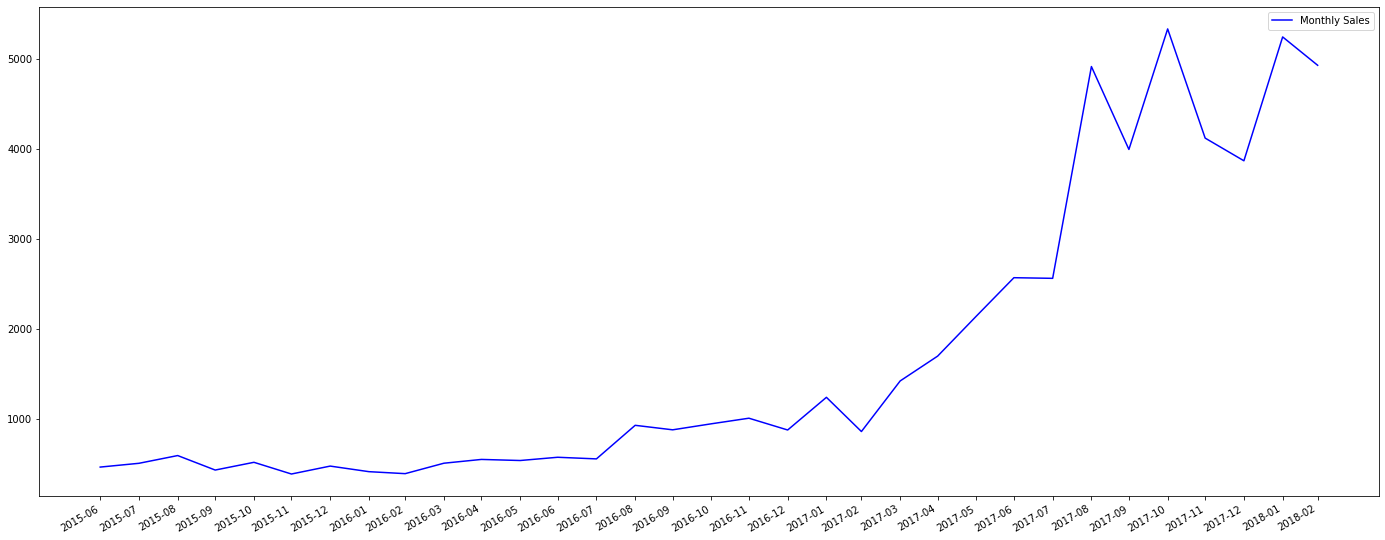

In [0]:
#plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator(interval=1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks( dev_count_monthly.index.values ) 

plt.plot(dev_count_monthly["count"], "-b", label='Monthly Sales')
plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

In [0]:
#creating a new dataframe modelling the difference
df_diff = dev_count_monthly.copy()

#add previous count to the next row
df_diff['prev_count'] = df_diff['count'].shift(1)

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff_count'] = (df_diff['count'] - df_diff['prev_count'])
df_diff.shape

(32, 3)

In [0]:
df_diff[0:3]

,count,prev_count,diff_count
date,,,
2015-07-31,503,461.0,42.0
2015-08-31,589,503.0,86.0
2015-09-30,428,589.0,-161.0


default: [24.0, 10.0]


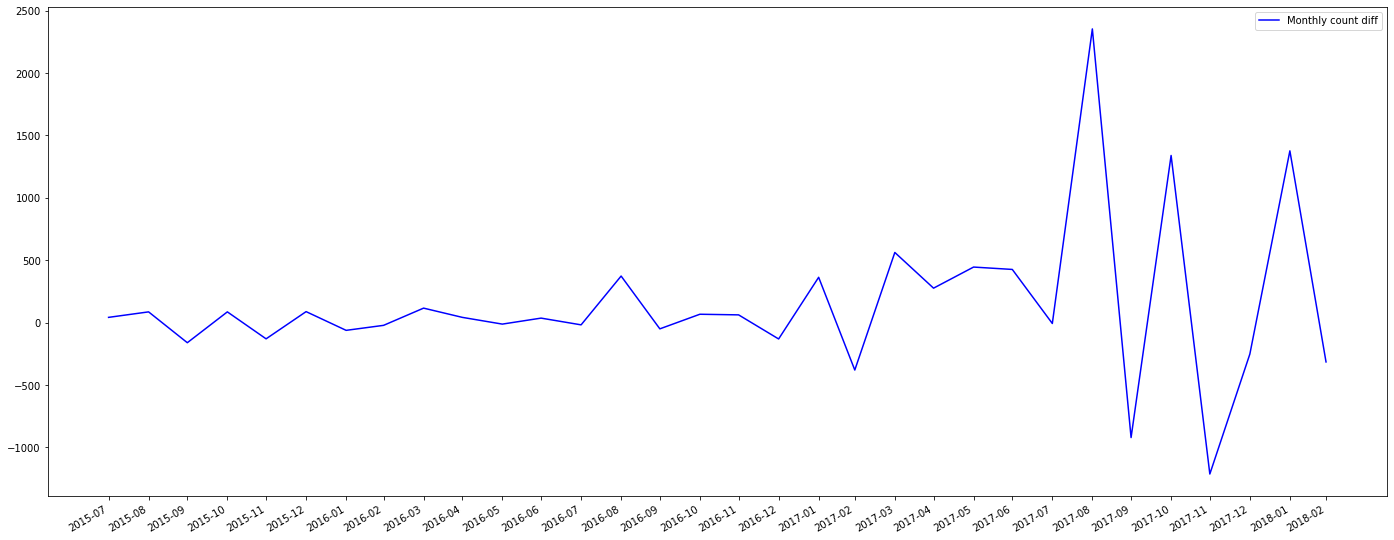

In [0]:
#plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator(interval=1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks( df_diff.index.values ) 

plt.plot(df_diff["diff_count"], "-b", label='Monthly count diff')
plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

The above graph looks stationary so we can model with these feature now

## 5. Preparing supervised data

### Check which feature set gives the maximum variation

In [0]:
#transformation from time series to supervised data sequence
df_supervised = df_diff.drop(['prev_count'],axis=1)

#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff_count'].shift(inc)

#drop null values
#df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised = df_supervised.dropna().reset_index(drop=False)

# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff_count ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)


0.5398317343131489


experiment using different features:  
lag_1 + lag_2  + lag_3 + lag_4 + lag_5 + lag_6 + lag_7  + lag_8 + lag_9 + lag_10 + lag_11 + lag_12 yeilds variation score 55.58%  


In [0]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_count'],axis=1)
#adding lags
# using till lag 12 gives best regression_adj_rsq, 
#but looking at the latest data which is increasing at a high rate thaninitial months, 3 lags are choosen
for l in range(1,4):
    field_name = 'lag_' + str(l)
    df_supervised[field_name] = df_supervised['count'].shift(l)
#drop null values
#df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [0]:
df_supervised[-8:]

,count,diff_count,lag_1,lag_2,lag_3
21,2558,-7.0,2565.0,2139.0,1694.0
22,4911,2353.0,2558.0,2565.0,2139.0
23,3990,-921.0,4911.0,2558.0,2565.0
24,5329,1339.0,3990.0,4911.0,2558.0
25,4116,-1213.0,5329.0,3990.0,4911.0
26,3864,-252.0,4116.0,5329.0,3990.0
27,5240,1376.0,3864.0,4116.0,5329.0
28,4925,-315.0,5240.0,3864.0,4116.0


In [0]:
df_supervised.shape

(29, 5)

In [0]:
#df_supervised.head

In [0]:
test_record_count = 9

In [0]:
df_lag_features = df_supervised.drop(['count'],axis=1)
#split train and test set
train_set, test_set = df_lag_features[0:-test_record_count].values, df_lag_features[-test_record_count:].values

In [0]:
train_set.shape

(20, 4)

In [0]:
test_set.shape

(9, 4)

In [0]:
df_lag_features

,diff_count,lag_1,lag_2,lag_3
0,86.0,428.0,589.0,503.0
1,-130.0,514.0,428.0,589.0
2,88.0,384.0,514.0,428.0
3,-62.0,472.0,384.0,514.0
4,-22.0,410.0,472.0,384.0
5,116.0,388.0,410.0,472.0
6,42.0,504.0,388.0,410.0
7,-12.0,546.0,504.0,388.0
8,36.0,534.0,546.0,504.0
9,-18.0,570.0,534.0,546.0


In [0]:
train_set

array([[  86.,  428.,  589.,  503.],
       [-130.,  514.,  428.,  589.],
       [  88.,  384.,  514.,  428.],
       [ -62.,  472.,  384.,  514.],
       [ -22.,  410.,  472.,  384.],
       [ 116.,  388.,  410.,  472.],
       [  42.,  504.,  388.,  410.],
       [ -12.,  546.,  504.,  388.],
       [  36.,  534.,  546.,  504.],
       [ -18.,  570.,  534.,  546.],
       [ 373.,  552.,  570.,  534.],
       [ -50.,  925.,  552.,  570.],
       [  67.,  875.,  925.,  552.],
       [  62.,  942.,  875.,  925.],
       [-131., 1004.,  942.,  875.],
       [ 363.,  873., 1004.,  942.],
       [-380., 1236.,  873., 1004.],
       [ 562.,  856., 1236.,  873.],
       [ 276., 1418.,  856., 1236.],
       [ 445., 1694., 1418.,  856.]])

In [0]:
test_set

array([[  426.,  2139.,  1694.,  1418.],
       [   -7.,  2565.,  2139.,  1694.],
       [ 2353.,  2558.,  2565.,  2139.],
       [ -921.,  4911.,  2558.,  2565.],
       [ 1339.,  3990.,  4911.,  2558.],
       [-1213.,  5329.,  3990.,  4911.],
       [ -252.,  4116.,  5329.,  3990.],
       [ 1376.,  3864.,  4116.,  5329.],
       [ -315.,  5240.,  3864.,  4116.]])

In [0]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(df_lag_features)
 
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [0]:
test_set

array([[  426.,  2139.,  1694.,  1418.],
       [   -7.,  2565.,  2139.,  1694.],
       [ 2353.,  2558.,  2565.,  2139.],
       [ -921.,  4911.,  2558.,  2565.],
       [ 1339.,  3990.,  4911.,  2558.],
       [-1213.,  5329.,  3990.,  4911.],
       [ -252.,  4116.,  5329.,  3990.],
       [ 1376.,  3864.,  4116.,  5329.],
       [ -315.,  5240.,  3864.,  4116.]])

In [0]:
test_set_scaled

array([[-0.08076276, -0.29019211, -0.47017189, -0.5817998 ],
       [-0.32361189, -0.11789687, -0.29019211, -0.47017189],
       [ 1.        , -0.12072801, -0.11789687, -0.29019211],
       [-0.83623107,  0.83094034, -0.12072801, -0.11789687],
       [ 0.43129557,  0.45844287,  0.83094034, -0.12072801],
       [-1.        ,  1.        ,  0.45844287,  0.83094034],
       [-0.46102075,  0.50940344,  1.        ,  0.45844287],
       [ 0.45204711,  0.40748231,  0.50940344,  1.        ],
       [-0.49635446,  0.96400404,  0.40748231,  0.50940344]])

In [0]:
# feature and label sets from scaled datasets
train_X, train_y = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])

X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [0]:
X_test.shape

(9, 1, 3)

## 6. Prepare LSTM Model

In [0]:
from keras import backend as K
from keras import optimizers

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TerminateOnNaN
from keras.callbacks import CSVLogger

In [0]:
# model callbacks.

# filepath under which the weights are saveed
model_checkpoint = ModelCheckpoint(filepath='diffcount_c1_epoch-{epoch:02d}_loss-{loss:.4f}.h5',
                               #    monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
callbacks = [model_checkpoint
            ]

In [0]:
# fit our LSTM model:
K.clear_session()  # Clear previous models from memory.    

model = Sequential()

#LSTM layer inputs shape of (batch_size, timesteps, input_dim)
#(timesteps, input_dim) for input_shape argument
# reshape(train_X.shape[0], 1, train_X.shape[1]), 1 in the reshape is the number of sequence
model.add(LSTM(4, batch_input_shape=(1, train_X.shape[1], train_X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

epochs = 100
# fit network
history = model.fit(train_X, train_y, 
                    epochs=epochs, 
                    batch_size=1, 
                    verbose=1,
                    callbacks=callbacks,
                    shuffle=False)


Epoch 1/100
20/20 [==============================] - 0s 25ms/step - loss: 0.4418
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.2996
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1697
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0024

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning:

Can save best model only with val_loss available, skipping.



20/20 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 11/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 12/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 13/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 14/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 15/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 16/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 17/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 18/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 19/100
20/20 [=======================

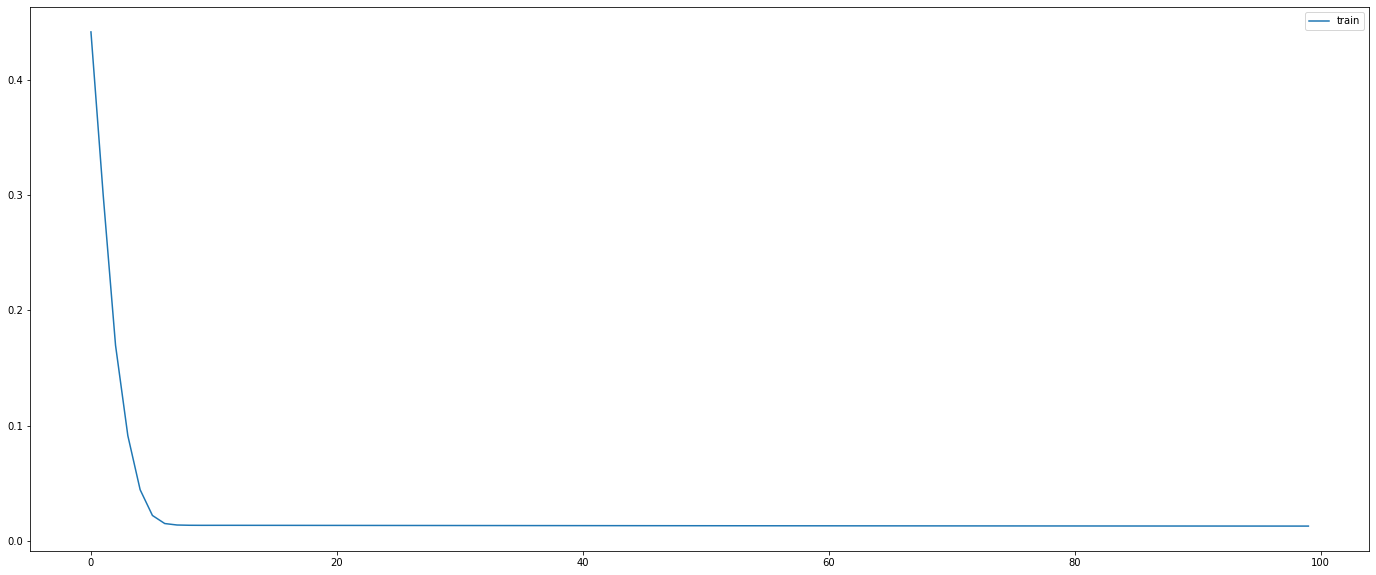

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig("diff_count_c1_lstm-training.png")
plt.show()

## 5. Validating the model with test data

In [0]:
y_pred = model.predict(X_test[-9:],batch_size=1)

In [0]:
#X_test

In [0]:
#X_test.shape

In [0]:
#y_pred

In [0]:
#y_pred.shape

In [0]:
#test_set[:, 0:1]

In [0]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [0]:
pred_test_set.shape

(9, 4)

In [0]:
#pred_test_set

In [0]:
#dev_count_monthly[-12:].index

In [0]:
#create dataframe that shows the predicted count
result_list = []
count_dates = list(dev_count_monthly[-9:].index)
act_count = list(dev_count_monthly["count"][-9:])
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    #print(pred_test_set_inverted[index][0], act_count[index])
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_count[index])
    result_dict['date'] = count_dates[index]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [0]:
#dev_count_monthly

In [0]:
result_list

[{'date': Timestamp('2017-06-30 00:00:00', freq='M'), 'pred_value': 2533},
 {'date': Timestamp('2017-07-31 00:00:00', freq='M'), 'pred_value': 2587},
 {'date': Timestamp('2017-08-31 00:00:00', freq='M'), 'pred_value': 5033},
 {'date': Timestamp('2017-09-30 00:00:00', freq='M'), 'pred_value': 4002},
 {'date': Timestamp('2017-10-31 00:00:00', freq='M'), 'pred_value': 5316},
 {'date': Timestamp('2017-11-30 00:00:00', freq='M'), 'pred_value': 3994},
 {'date': Timestamp('2017-12-31 00:00:00', freq='M'), 'pred_value': 3743},
 {'date': Timestamp('2018-01-31 00:00:00', freq='M'), 'pred_value': 5259},
 {'date': Timestamp('2018-02-28 00:00:00', freq='M'), 'pred_value': 4765}]

In [0]:
df_result

,pred_value,date
0,2533,2017-06-30
1,2587,2017-07-31
2,5033,2017-08-31
3,4002,2017-09-30
4,5316,2017-10-31
5,3994,2017-11-30
6,3743,2017-12-31
7,5259,2018-01-31
8,4765,2018-02-28


In [0]:
#act_count

In [0]:
#merging predicted with actual sales dataframe

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

df_count_pred = pd.merge(dev_count_monthly,df_result,on='date',how='left')#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_count_pred['date'],
        y=df_count_pred['count'],
        name='actual'
    ),
        go.Scatter(
        x=df_count_pred['date'],
        y=df_count_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Count Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

It looks like the model is merging well while predicting the variation for the next month.

In [0]:
#df_count_pred

In [0]:
#dev_count_monthly

In [0]:
#!pip install chart-studio

## 6. Prediction for next year 

In [0]:
#df_lag_features

In [0]:
#apply Min Max Scaler
scaler_ = MinMaxScaler(feature_range=(-1, 1))
scaler_ = scaler_.fit(df_lag_features.iloc[:,1:4])

In [0]:
future_months_no = 12
next_year=list()
input_next_year_X = test_set[-1:,1:]
pred_count = df_supervised["count"][-1:].values[0]

for i in range(1, future_months_no + 1):
    # make a prediction
    #print("Predict %d day"%i)
    scaled_X = scaler_.transform(input_next_year_X)
    scaled_X = scaled_X.reshape(1, scaled_X.shape[0], scaled_X.shape[1])

    yhat = model.predict(scaled_X)

    #reshape y_pred for inverse transform
    yhat = yhat.reshape(yhat.shape[0], 1, yhat.shape[1])
    pred_test_set = []
    for index in range(0,len(yhat)):
        pred_test_set.append(np.concatenate([yhat[index],X_test[index]],axis=1))
 
    pred_test_set = np.array(pred_test_set)

    #reshape pred_test_set
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

    #inverse transform
    pred_test_set_inv = scaler.inverse_transform(pred_test_set)
   
    next_year.append(pred_count + pred_test_set_inv[0][0])
    pred_count = pred_count + pred_test_set_inv[0][0]

    # prepare the input for next prediction using the previous predicted value
    input_next_year_X = np.delete(input_next_year_X[0], 2)
    input_next_year_X = np.insert(input_next_year_X, 0, pred_count)
    input_next_year_X = input_next_year_X.reshape( 1, input_next_year_X.shape[0])

In [0]:
#len(next_year)
#next_year

default: [24.0, 10.0]


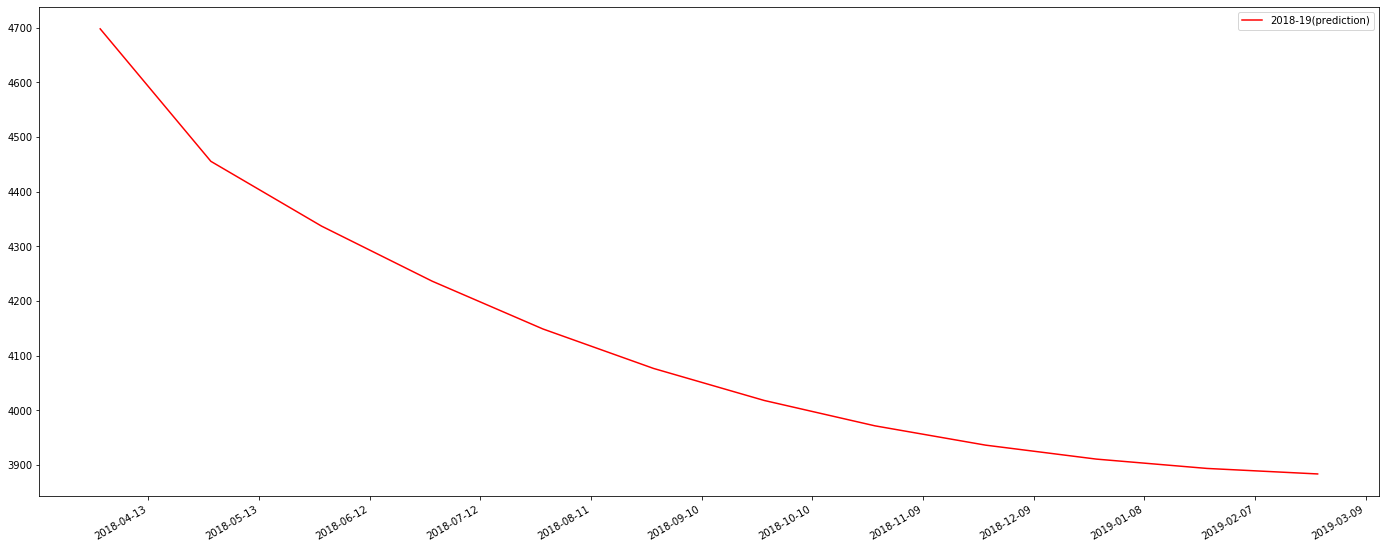

In [0]:
start = pd.Timestamp('2018-03-31')
end = start + timedelta(days=30 * future_months_no)
days = mdates.drange(start, end, timedelta(days=30))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

#plt.plot(days, values, "-b", label='2017-18') # previous year
plt.plot(days, next_year,    "-r"   , label='2018-19(prediction)')   # forecast

plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

The graph does not show well any variation on a monthly basis. Reason is due to using the predicted value as input for further future prediction.  
Instead predicting for a short term with this model would be appropriate.  
However supplying the model actual previous month data it could predict next month sales.  

## 7. Predict for Next (3) month

In [0]:
future_months_no = 3
next_year=list()
input_next_year_X = test_set[-1:,1:]
pred_count = df_supervised["count"][-1:].values[0]

for i in range(1, future_months_no + 1):
    # make a prediction
    #print("Predict %d day"%i)
    scaled_X = scaler_.transform(input_next_year_X)

    #input_next_year_X = input_next_year_X[0:,1:]
    scaled_X = scaled_X.reshape(1, scaled_X.shape[0], scaled_X.shape[1])

    yhat = model.predict(scaled_X)
    #reshape y_pred for inverse transform
    yhat = yhat.reshape(yhat.shape[0], 1, yhat.shape[1])
    pred_test_set = []
    for index in range(0,len(yhat)):
        pred_test_set.append(np.concatenate([yhat[index],X_test[index]],axis=1))
 
    pred_test_set = np.array(pred_test_set)
    #reshape pred_test_set
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    #inverse transform
    pred_test_set_inv = scaler.inverse_transform(pred_test_set)
   
    next_year.append(pred_count + pred_test_set_inv[0][0])

    pred_count = pred_count + pred_test_set_inv[0][0]

    # prepare the input for next prediction using the previous predicted value
    input_next_year_X = np.delete(input_next_year_X[0], 2)
    input_next_year_X = np.insert(input_next_year_X, 0, pred_count)
    input_next_year_X = input_next_year_X.reshape( 1, input_next_year_X.shape[0])

In [0]:
#next_year

In [0]:
predictions = result_list.copy()

for index in range(0,len(next_year)):
  date = pd.Timestamp('2018-03-31') + timedelta(days = 30 * index)
  result_dict = {}
  result_dict['pred_value'] = int(next_year[index])
  result_dict['date'] = date
  predictions.append(result_dict)

df_predictions = pd.DataFrame(predictions)

In [0]:
df_future

,pred_value,date
0,2818,2017-06-30
1,2856,2017-07-31
2,5253,2017-08-31
3,4215,2017-09-30
4,5499,2017-10-31
5,4099,2017-11-30
6,3824,2017-12-31
7,5315,2018-01-31
8,4805,2018-02-28
9,4767,2018-03-31


In [0]:
#merging predicted with actual sales dataframe

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

df_count_pred = pd.merge(dev_count_monthly,df_predictions,on='date',how='outer')#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_count_pred['date'],
        y=df_count_pred['count'],
        name='actual'
    ),
        go.Scatter(
        x=df_count_pred['date'],
        y=df_count_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Count Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

The model shows a very good approximation while predicting 9 months from test data.  
9 data point prediction from Jun 30, 2017 till Feb 28, 2018)  
Model showing good approximation for next three months.  
After that showing a decreasing trend at this point!  
Additional features and better model is needed to predict both up-down  

# Task 3

In [0]:
df_device_daily = pd.read_csv(data_path + "unique_device_daily.csv", delimiter=",")

In [0]:
df_device_daily.date = pd.to_datetime(df_device_daily.date)

In [67]:
df_device_daily.head

<bound method NDFrame.head of        device_id  user_id       date
0            100        4 2015-05-31
1            101        1 2015-05-31
2            102        1 2015-05-31
3            103       26 2015-05-31
4            104        1 2015-05-31
...          ...      ...        ...
56582      56298     4445 2018-02-28
56583      56299     5455 2018-02-28
56584      56300     4824 2018-02-28
56585      56301     4445 2018-02-28
56586      56302     5219 2018-02-28

[56587 rows x 3 columns]>

In [0]:
last_date = df_device_daily.date.max()

In [69]:
last_date

Timestamp('2018-02-28 00:00:00')

In [0]:
last_3_month= last_date - timedelta(days = 30 * 3)

In [75]:
last_3_month

Timestamp('2017-11-30 00:00:00')

In [0]:
last_6_month = last_date - timedelta(days = 30 * 6)

In [122]:
last_6_month

Timestamp('2017-09-01 00:00:00')

In [0]:
df_reference = df_device_daily[(df_device_daily.date > last_6_month) & (df_device_daily.date < last_3_month) ]

In [124]:
df_reference.head

<bound method NDFrame.head of        device_id  user_id       date
29199      29080     1220 2017-09-02
29200      29081     2035 2017-09-02
29201      29082     2035 2017-09-02
29202      29083     2035 2017-09-02
29203      29084     2035 2017-09-02
...          ...      ...        ...
42298      42067     3261 2017-11-29
42299      42068     1220 2017-11-29
42300      42069     3261 2017-11-29
42882      15082     2035 2017-11-28
42883      15082     2035 2017-11-29

[13049 rows x 3 columns]>

In [0]:
df_recent = df_device_daily[(df_device_daily.date > last_3_month) ]

In [126]:
df_recent.head

<bound method NDFrame.head of        device_id  user_id       date
42555      42324     1220 2017-12-01
42556      42325     1220 2017-12-01
42557      42326     1220 2017-12-01
42558      42327     2519 2017-12-01
42559      42328     4179 2017-12-01
...          ...      ...        ...
56582      56298     4445 2018-02-28
56583      56299     5455 2018-02-28
56584      56300     4824 2018-02-28
56585      56301     4445 2018-02-28
56586      56302     5219 2018-02-28

[14029 rows x 3 columns]>

In [0]:
user_list_ref = df_reference.user_id.values # numpy.ndarray

In [0]:
user_list_ref = np.unique(user_list_ref)

In [130]:
len(user_list_ref)

1298

In [0]:
user_list = df_recent.user_id.values # numpy.ndarray

In [0]:
user_list = np.unique(user_list)

In [134]:
len(user_list)

1667

### Find those users, who were active within a period of 3 months prior to previous 3 months, but are no more active within last 3 months

In [0]:
immediate_contact_user_list = np.setdiff1d(user_list_ref, user_list)

In [136]:
len(immediate_contact_user_list) 

890

In [137]:
immediate_contact_user_list

array([   4,   21,   38,   45,   77,   81,   86,  110,  113,  192,  205,
        259,  262,  312,  319,  365,  366,  476,  493,  512,  519,  525,
        589,  683,  735,  747,  781,  789,  794,  810,  815,  879,  906,
        918,  988,  996, 1007, 1085, 1086, 1089, 1090, 1115, 1136, 1164,
       1205, 1233, 1248, 1320, 1333, 1345, 1381, 1394, 1413, 1435, 1449,
       1464, 1468, 1483, 1544, 1668, 1689, 1715, 1722, 1736, 1753, 1782,
       1817, 1837, 1851, 1859, 1861, 1869, 1878, 1886, 1895, 1899, 1908,
       1910, 1919, 1923, 1926, 1942, 1965, 1981, 1982, 1986, 2015, 2031,
       2042, 2062, 2077, 2087, 2195, 2208, 2220, 2233, 2250, 2290, 2313,
       2328, 2341, 2345, 2348, 2365, 2379, 2405, 2407, 2414, 2439, 2452,
       2470, 2524, 2536, 2566, 2582, 2602, 2608, 2612, 2613, 2652, 2694,
       2695, 2701, 2707, 2708, 2710, 2726, 2727, 2731, 2741, 2762, 2774,
       2789, 2817, 2828, 2832, 2841, 2850, 2854, 2865, 2872, 2874, 2875,
       2888, 2893, 2902, 2922, 2936, 2943, 2954, 29

**Above is the list of user id, they were active in a period of 3 months prior to the last 3-months, but not active in the last three months, that indicates they are in a process of churning** 

Further filtering is required to filter those users who had certain number od devices active during that period, and are not so critical from the revenue point of view than others who had more number of devices and are not active any more, and this is critical as we are losing revenues for such users.